# Predicting Machine Failure
The manufacturing team has been suffering consistent machine breakdowns and they want to be able to idenfy it before it's likely to happen through their sensor data. The existing machines have a number of sensors but they're not too sure which help identify failure.

# 1. Import Data

## Connect to SQL Database

In [4]:
# Import core dependencies
import os
import sqlite3
import pandas as pd
import numpy as np

%load_ext jupyter_black

The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black


In [2]:
# Path to DB
from pathlib import Path

DB_PATH = Path("database") / "iot.db"
DB_PATH

PosixPath('database/iot.db')

In [3]:
# Setup connection and cursor to DB
con = sqlite3.connect(DB_PATH)
cur = con.cursor()

## Check What Tables are Available

In [6]:
TABLE_STATEMENT = """
    SELECT
        name
    FROM
        sqlite_master
    WHERE
        type="table"
"""

In [16]:
res = cur.execute(TABLE_STATEMENT)
tables = res.fetchall()
tables

[('training',), ('scoring',)]

## Check What Fields are Available?

In [11]:
COLUMN_STATEMENT = """
    PRAGMA table_info(training)
"""

In [19]:
res = cur.execute(COLUMN_STATEMENT)
columns = res.fetchall()
columns[-10:]

[(93, 'Sensor 94', '', 0, None, 0),
 (94, 'Sensor 95', '', 0, None, 0),
 (95, 'Sensor 96', '', 0, None, 0),
 (96, 'Sensor 97', '', 0, None, 0),
 (97, 'Sensor 98', '', 0, None, 0),
 (98, 'Sensor 99', '', 0, None, 0),
 (99, 'Sensor 100', '', 0, None, 0),
 (100, 'Sensor 101', '', 0, None, 0),
 (101, 'Sensor 102', '', 0, None, 0),
 (102, 'Machine Failure', '', 0, None, 0)]

## Get a Few Columns from DB

In [34]:
FILTERED_STATEMENT = """
    SELECT
        "Sensor 1",
        "Sensor 2",
        "Sensor 3",
        "Sensor 4"
    FROM
        training
    WHERE
        "Sensor 1" > 0.3
"""

In [35]:
res = cur.execute(FILTERED_STATEMENT)
data = res.fetchall()
data[:10]

[(2.106008243, 1.765493708, 0.072487791, 0.164543308),
 (2.400996766, 0.410752315, 0.745568541, 1.467639639),
 (0.675426655, 1.217458087, 1.491453913, 0.65860241),
 (1.745152966, 1.174935424, 2.206421856, 1.79379992),
 (2.090793093, 1.094919373, 0.785265868, 1.364575247),
 (2.79645866, 2.085578317, -0.103897593, 0.216506322),
 (0.724899608, 0.39124623, 1.03709285, -0.207572927),
 (0.451909781, 1.895814744, 2.198726339, 1.098719827),
 (0.431952385, 0.614855731, 0.942807588, -0.566254373),
 (2.841511193, 1.200553697, 1.336784994, 1.873368442)]

In [37]:
cols = np.array(cur.description)[:, 0]
df = pd.DataFrame(data, columns=cols)
df.head()

,Sensor 1,Sensor 2,Sensor 3,Sensor 4
0,2.106008,1.765494,0.072488,0.164543
1,2.400997,0.410752,0.745569,1.467640
2,0.675427,1.217458,1.491454,0.658602
3,1.745153,1.174935,2.206422,1.793800
4,2.090793,1.094919,0.785266,1.364575


## Get All the Data

In [38]:
ALL_DATA_STATEMENT = """
    SELECT
        *
    FROM
        training
"""

## Convert SQL Result into a DataFrame

In [40]:
res = cur.execute(ALL_DATA_STATEMENT)
data = res.fetchall()
cols = np.array(cur.description)[:, 0]
df = pd.DataFrame(data, columns=cols)
df.head()

,Sensor 1,Sensor 2,Sensor 3,Sensor 4,Sensor 5,Sensor 6,Sensor 7,Sensor 8,Sensor 9,Sensor 10,...,Sensor 94,Sensor 95,Sensor 96,Sensor 97,Sensor 98,Sensor 99,Sensor 100,Sensor 101,Sensor 102,Machine Failure
0,2.106008,1.765494,0.072488,0.164543,2.928143,1.645433,1.819063,0.332035,0.665590,24.531377,...,1.668703,-1.748165,0.075639,2.383862,-0.556234,0.152506,51.825760,49.461068,14.322512,Running
1,2.400997,0.410752,0.745569,1.467640,-1.136906,14.676396,0.257288,0.892593,1.418290,18.658616,...,1.835808,-1.923228,1.488724,2.622583,-0.611936,1.178079,5.891962,42.905350,14.279731,Running
2,0.675427,1.217458,1.491454,0.658602,0.947287,6.586024,2.771511,5.866576,1.928395,27.855573,...,1.411937,-1.479172,-0.942776,2.017053,-0.470646,1.153371,21.134473,-54.254697,14.196304,Running
3,0.295065,2.583267,1.397774,1.222003,0.384710,12.220032,2.332653,14.873609,3.130726,41.486420,...,-0.843319,0.883477,0.568646,-1.204742,0.281106,0.932500,33.129568,44.200473,14.168624,Running
4,1.745153,1.174935,2.206422,1.793800,0.646555,17.937999,2.027426,2.042624,0.336993,9.490009,...,-0.490529,0.513887,-0.244071,-0.700755,0.163510,0.737156,45.813705,42.141305,14.189116,Running


In [42]:
df.shape

(6530, 103)

In [41]:
# Close connection to database
cur.close()
con.close()

# 2. Split Data into Train and Testing to Prevent Data Snooping Bias

In [43]:
from sklearn.model_selection import train_test_split

In [44]:
train, test = train_test_split(
    df, stratify=df["Machine Failure"], test_size=0.3, random_state=1234
)

In [48]:
train.shape

(4571, 103)

# 3. Exploratory Data Analysis

## Bird's Eye Overview

In [52]:
train.head()

,Sensor 1,Sensor 2,Sensor 3,Sensor 4,Sensor 5,Sensor 6,Sensor 7,Sensor 8,Sensor 9,Sensor 10,Sensor 11,Sensor 12,Sensor 13,Sensor 14,Sensor 15,Sensor 16,Sensor 17,Sensor 18,Sensor 19,Sensor 20,Sensor 21,Sensor 22,Sensor 23,Sensor 24,Sensor 25,Sensor 26,Sensor 27,Sensor 28,Sensor 29,Sensor 30,Sensor 31,Sensor 32,Sensor 33,Sensor 34,Sensor 35,Sensor 36,Sensor 37,Sensor 38,Sensor 39,Sensor 40,Sensor 41,Sensor 42,Sensor 43,Sensor 44,Sensor 45,Sensor 46,Sensor 47,Sensor 48,Sensor 49,Sensor 50,Sensor 51,Sensor 52,Sensor 53,Sensor 54,Sensor 55,Sensor 56,Sensor 57,Sensor 58,Sensor 59,Sensor 60,Sensor 61,Sensor 62,Sensor 63,Sensor 64,Sensor 65,Sensor 66,Sensor 67,Sensor 68,Sensor 69,Sensor 70,Sensor 71,Sensor 72,Sensor 73,Sensor 74,Sensor 75,Sensor 76,Sensor 77,Sensor 78,Sensor 79,Sensor 80,Sensor 81,Sensor 82,Sensor 83,Sensor 84,Sensor 85,Sensor 86,Sensor 87,Sensor 88,Sensor 89,Sensor 90,Sensor 91,Sensor 92,Sensor 93,Sensor 94,Sensor 95,Sensor 96,Sensor 97,Sensor 98,Sensor 99,Sensor 100,Sensor 101,Sensor 102,Machine Failure
1526,1.382209,0.959569,2.039691,1.631576,1.471266,16.315762,-0.123216,-0.498342,1.487315,26.543901,-1.681403,-11.966185,8.271950,1.364552,0.740828,26.543901,-1.681403,-11.966185,8.271950,1.364552,0.740828,0.006143,1.029249,1.688247,-0.114838,10.103891,10.192126,10.051987,14.251942,14.314632,14.215192,17.439814,17.491081,17.409794,20.128993,20.173427,20.102989,13.478877,10.968783,0.855048,0.941854,1.471266,0.080731,1.921926,1.184856,0.111871,1.471266,0.183842,0.215007,0.007371,1.096878,0.228281,0.228281,0.001738,0.001846,0.057161,9.402169,2.727626,1.360505,-0.102864,1.930407,-0.818318,0.125710,1.763584,0.185371,12.595135,15.114162,18.136994,21.764393,26.117271,31.340726,37.608871,45.130645,54.156774,64.988129,77.985755,93.582906,112.299487,0.838036,1.828243,0.423469,0.423469,0.423469,0.423469,0.423469,0.423469,0.423469,1.205233,5.484730,2.798237,-0.796498,5.008164,-0.677723,-0.711609,0.745496,-0.102864,-1.016585,0.237203,0.774204,-11.966185,93.582906,14.215192,Running
2814,1.114661,1.753120,0.777757,-1.165778,1.167658,-11.657782,0.838125,-3.917132,2.405440,13.810468,24.548010,-7.777302,1.905234,2.116446,2.311702,13.810468,24.548010,-7.777302,1.905234,2.116446,2.311702,-0.103996,3.296675,1.798160,1.997290,10.684790,10.321340,10.357888,14.746573,14.485397,14.511462,17.909720,17.695293,17.716636,20.592590,20.406373,20.424883,5.172502,7.050766,1.598879,-0.457077,1.167658,0.196142,2.545204,-0.853337,-0.104683,1.167658,-0.426005,-0.266440,-0.124795,0.705077,0.582921,0.582921,0.023444,-0.051291,0.239583,17.280406,1.668045,2.203358,0.682722,0.674557,0.725812,1.600185,1.273691,2.517204,-5.784908,-6.941890,-8.330268,-9.996321,-11.995586,-14.394703,-17.273643,-20.728372,-24.874046,-29.848855,-35.818627,-42.982352,-51.578822,0.701181,1.843427,-0.579114,-0.579114,-0.579114,-0.579114,-0.579114,-0.579114,-0.579114,0.490554,5.530280,1.150180,-0.151168,28.697889,4.822310,5.063426,-5.304542,0.682722,7.233466,-1.687809,-1.067554,-7.777302,-42.982352,14.511462,Running
6488,0.919949,-0.244303,0.442553,-0.542031,0.603301,-5.420310,1.906050,-0.214311,0.124462,10.368780,5.364259,11.428224,0.184390,0.214901,1.932328,10.368780,5.364259,11.428224,0.184390,0.214901,1.932328,0.890976,2.327950,-0.493759,1.288856,10.380140,10.127771,10.197505,14.493973,14.314318,14.363741,17.674932,17.527911,17.568295,20.364949,20.237480,20.272468,9.373816,0.960958,-0.170585,1.305511,0.603301,-1.896878,1.550714,-0.134356,-1.494011,0.603301,0.395210,-2.316785,1.069172,0.096096,-1.774619,-1.774619,-0.238033,-0.182329,0.302632,-6.529273,2.817630,1.437235,0.890708,-0.619939,1.255193,2.166722,0.340220,0.894706,-4.591103,-5.509323,-6.611188,-7.933426,-9.520111,-11.424133,-13.708959,-16.450751,-19.740901,-23.689082,-28.426898,-34.112278,-40.934733,1.745349,-0.899083,-0.181665,-0.181665,-0.181665,-0.181665,-0.181665,-0.181665,-0.181665,0.453108,-2.697248,-0.844321,0.753698,19.702449,3.282184,3.446293,-3.610402,0.890708,4.923276,-1.148764,0.163332,11.428224,-34.112278,14.3

In [50]:
train["Machine Failure"].unique()

array(['Running', 'Failure'], dtype=object)

In [60]:
# Update max columns to display
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
# pd.reset_option("display.max_rows")

In [53]:
train.tail()

,Sensor 1,Sensor 2,Sensor 3,Sensor 4,Sensor 5,Sensor 6,Sensor 7,Sensor 8,Sensor 9,Sensor 10,Sensor 11,Sensor 12,Sensor 13,Sensor 14,Sensor 15,Sensor 16,Sensor 17,Sensor 18,Sensor 19,Sensor 20,Sensor 21,Sensor 22,Sensor 23,Sensor 24,Sensor 25,Sensor 26,Sensor 27,Sensor 28,Sensor 29,Sensor 30,Sensor 31,Sensor 32,Sensor 33,Sensor 34,Sensor 35,Sensor 36,Sensor 37,Sensor 38,Sensor 39,Sensor 40,Sensor 41,Sensor 42,Sensor 43,Sensor 44,Sensor 45,Sensor 46,Sensor 47,Sensor 48,Sensor 49,Sensor 50,Sensor 51,Sensor 52,Sensor 53,Sensor 54,Sensor 55,Sensor 56,Sensor 57,Sensor 58,Sensor 59,Sensor 60,Sensor 61,Sensor 62,Sensor 63,Sensor 64,Sensor 65,Sensor 66,Sensor 67,Sensor 68,Sensor 69,Sensor 70,Sensor 71,Sensor 72,Sensor 73,Sensor 74,Sensor 75,Sensor 76,Sensor 77,Sensor 78,Sensor 79,Sensor 80,Sensor 81,Sensor 82,Sensor 83,Sensor 84,Sensor 85,Sensor 86,Sensor 87,Sensor 88,Sensor 89,Sensor 90,Sensor 91,Sensor 92,Sensor 93,Sensor 94,Sensor 95,Sensor 96,Sensor 97,Sensor 98,Sensor 99,Sensor 100,Sensor 101,Sensor 102,Machine Failure
2710,-0.340178,1.294278,0.781184,-1.480923,0.068733,-14.809227,1.906972,-17.471799,3.712036,-0.380248,22.159835,21.657676,-5.190124,1.478616,1.756826,-0.380248,22.159835,21.657676,-5.190124,1.478616,1.756826,0.385086,0.454042,0.011809,2.168049,10.032955,10.022683,10.254486,14.181475,14.174210,14.339056,17.365721,17.359789,17.494644,20.050494,20.045356,20.162257,5.133131,4.841805,2.212095,-0.560806,0.068733,2.398764,0.751035,-0.085267,-0.092462,0.068733,-0.153613,-0.069442,0.462104,0.484180,0.123826,0.123826,-0.015537,0.027705,0.007424,6.218980,0.626622,1.521575,-0.932482,2.699274,0.873718,1.268828,1.223922,-0.366679,12.216478,14.659774,17.591728,21.110074,25.332089,30.398506,36.478208,43.773849,52.528619,63.034343,75.641212,90.769454,108.923345,0.852094,-0.051008,0.173435,0.173435,0.173435,0.173435,0.173435,0.173435,0.173435,1.970726,-0.153023,0.986703,1.388508,17.196463,3.626465,3.807788,-3.989111,-0.932482,5.439697,-1.269263,-0.008847,21.657676,90.769454,14.339056,Running
5934,-0.310678,1.856229,0.641760,0.546215,1.165328,5.462155,1.566315,-0.314224,-0.220368,7.411216,41.331922,26.189019,-1.294392,9.816893,-1.435316,7.411216,41.331922,26.189019,-1.294392,9.816893,-1.435316,0.088468,0.268201,2.861348,2.393097,10.016992,10.414198,10.295393,14.163627,14.447274,14.361870,17.345793,17.578166,17.508041,20.028598,20.230178,20.169277,4.358964,3.087912,1.043529,-0.507114,1.165328,2.305146,0.519839,-0.616678,-1.362236,1.165328,-0.738968,-0.708143,0.106162,0.308791,1.396418,1.396418,-0.023214,0.045777,0.602138,-0.921657,0.927856,0.465987,1.741442,1.522061,0.123318,1.500047,0.961891,1.023063,-4.401882,-5.282258,-6.338710,-7.606452,-9.127742,-10.953290,-13.143949,-15.772738,-18.927286,-22.712743,-27.255292,-32.706350,-39.247620,1.011587,2.062418,0.185852,0.185852,0.185852,0.185852,0.185852,0.185852,0.185852,1.397820,6.187253,0.153970,1.929666,-2.062546,1.423834,1.495025,-1.566217,1.741442,2.135751,-0.498342,0.383304,26.189019,-32.706350,14.361870,Running
6495,3.317952,1.380904,0.702294,0.841608,1.849806,8.416081,1.665403,0.546900,0.234116,-6.652780,11.251962,15.287858,-8.326390,0.015674,0.998611,-6.652780,11.251962,15.287858,-8.326390,0.015674,0.998611,0.614885,-0.127624,0.195180,0.606461,9.994432,9.995523,10.012001,14.133685,14.134456,14.146114,17.309922,17.310552,17.320073,19.987641,19.988187,19.996432,2.250449,8.959334,3.542002,1.257048,1.849806,1.841352,0.595787,8.236199,4.281687,1.849806,9.035548,2.550972,0.737862,0.895933,2.029336,2.029336,1.686384,1.341543,3.689636,2.925354,-0.059217,-0.975081,1.412931,-0.663128,1.869017,2.206938,0.670450,2.102636,3.386107,4.063328,4.875993,5.851192,7.021431,8.425717,10.110860,12.133032,14.559638,17.471566,20.965879,25.159055,30.190866,1.676480,2.060402,1.802104,1.802104,1.802104,1.802104,1.802104,1.802104,1.802104,0.020928,6.181207,0.846722,1.909574,13.410566,2.879640,3.023622,-3.167604,1.412931,4.319461,-1.007874,3.713060,15.287858,25.159055,14.146114,Running
2031,0.942987,1.208896,0.

In [61]:
train.dtypes

Sensor 1           float64
Sensor 2           float64
Sensor 3           float64
Sensor 4           float64
Sensor 5           float64
Sensor 6           float64
Sensor 7           float64
Sensor 8           float64
Sensor 9           float64
Sensor 10          float64
Sensor 11          float64
Sensor 12          float64
Sensor 13          float64
Sensor 14          float64
Sensor 15          float64
Sensor 16          float64
Sensor 17          float64
Sensor 18          float64
Sensor 19          float64
Sensor 20          float64
Sensor 21          float64
Sensor 22          float64
Sensor 23          float64
Sensor 24          float64
Sensor 25          float64
Sensor 26          float64
Sensor 27          float64
Sensor 28          float64
Sensor 29          float64
Sensor 30          float64
Sensor 31          float64
Sensor 32          float64
Sensor 33          float64
Sensor 34          float64
Sensor 35          float64
Sensor 36          float64
Sensor 37          float64
S

In [62]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4571 entries, 1526 to 4397
Columns: 103 entries, Sensor 1 to Machine Failure
dtypes: float64(102), object(1)
memory usage: 3.6+ MB


In [63]:
train.describe()

,Sensor 1,Sensor 2,Sensor 3,Sensor 4,Sensor 5,Sensor 6,Sensor 7,Sensor 8,Sensor 9,Sensor 10,Sensor 11,Sensor 12,Sensor 13,Sensor 14,Sensor 15,Sensor 16,Sensor 17,Sensor 18,Sensor 19,Sensor 20,Sensor 21,Sensor 22,Sensor 23,Sensor 24,Sensor 25,Sensor 26,Sensor 27,Sensor 28,Sensor 29,Sensor 30,Sensor 31,Sensor 32,Sensor 33,Sensor 34,Sensor 35,Sensor 36,Sensor 37,Sensor 38,Sensor 39,Sensor 40,Sensor 41,Sensor 42,Sensor 43,Sensor 44,Sensor 45,Sensor 46,Sensor 47,Sensor 48,Sensor 49,Sensor 50,Sensor 51,Sensor 52,Sensor 53,Sensor 54,Sensor 55,Sensor 56,Sensor 57,Sensor 58,Sensor 59,Sensor 60,Sensor 61,Sensor 62,Sensor 63,Sensor 64,Sensor 65,Sensor 66,Sensor 67,Sensor 68,Sensor 69,Sensor 70,Sensor 71,Sensor 72,Sensor 73,Sensor 74,Sensor 75,Sensor 76,Sensor 77,Sensor 78,Sensor 79,Sensor 80,Sensor 81,Sensor 82,Sensor 83,Sensor 84,Sensor 85,Sensor 86,Sensor 87,Sensor 88,Sensor 89,Sensor 90,Sensor 91,Sensor 92,Sensor 93,Sensor 94,Sensor 95,Sensor 96,Sensor 97,Sensor 98,Sensor 99,Sensor 100,Sensor 101,Sensor 102
count,4571.000000,4571.000000,4571.000000,4571.000000,4571.000000,4571.000000,4571.000000,4571.000000,4571.000000,4571.000000,4571.000000,4571.000000,4571.000000,4.571000e+03,4571.000000,4571.000000,4571.000000,4571.000000,4571.000000,4.571000e+03,4571.000000,4571.000000,4571.000000,4571.000000,4571.000000,4571.000000,4571.000000,4571.000000,4571.000000,4571.000000,4571.000000,4571.000000,4571.000000,4571.000000,4571.000000,4571.000000,4571.000000,4571.000000,4571.000000,4571.000000,4571.000000,4571.000000,4571.000000,4571.000000,4571.000000,4571.000000,4571.000000,4571.000000,4571.000000,4571.000000,4571.000000,4571.000000,4571.000000,4571.000000,4571.000000,4571.000000,4571.000000,4571.000000,4571.000000,4571.000000,4571.000000,4571.000000,4571.000000,4571.000000,4571.000000,4571.000000,4571.000000,4571.000000,4571.000000,4571.000000,4571.000000,4571.000000,4571.000000,4571.000000,4571.000000,4571.000000,4571.000000,4571.000000,4571.000000,4571.000000,4571.000000,4571.000000,4571.000000,4571.000000,4571.000000,4571.000000,4571.000000,4571.000000,4571.000000,4571.000000,4571.000000,4571.000000,4571.000000,4571.000000,4571.000000,4571.000000,4571.000000,4571.000000,4571.000000,4571.000000,4571.000000,4571.000000
mean,1.017857,0.987795,0.997633,1.007020,0.986144,10.070205,1.036881,1.638584,0.963613,14.714748,16.343000,14.908261,2.357374,2.984878e+00,1.007779,14.714748,16.343000,14.908261,2.357374,2.984878e+00,1.007779,1.005972,1.034620,1.012852,1.008781,10.152158,10.152033,10.150611,14.286539,14.286461,14.285442,17.468247,17.468187,17.467351,20.153734,20.153683,20.152958,4.871498,5.107285,1.005360,1.015729,0.986144,1.001372,0.981653,0.956550,1.005444,0.986144,0.999324,0.968234,1.207166,0.510729,0.956168,0.956168,0.638479,0.593558,3.731680,11.211629,1.002373,0.992859,1.011089,0.992396,0.984685,0.988718,1.023633,1.012122,5.955212,7.146254,8.575505,10.290606,12.348727,14.818473,17.782167,21.338601,25.606321,30.727585,36.873102,44.247723,53.097267,1.011652,1.021844,1.014178,1.014178,1.014178,1.014178,1.014178,1.014178,1.014178,1.011044,3.065531,0.985513,1.014776,9.955648,1.999458,2.099431,-2.199404,1.011089,2.999187,-0.699810,1.038502,14.908261,44.247723,14.285442
std,0.979800,0.990494,0.998358,1.001622,1.024145,10.016223,1.012838,4.391955,1.003892,15.213086,16.072047,14.989871,7.606543,4.178067e+00,1.005145,15.213086,16.072047,14.989871,7.606543,4.178067e+00,1.005145,0.996170,0.993661,1.010078,0.999609,0.160932,0.129425,0.127920,0.147089,0.110368,0.109676,0.147588,0.110543,0.110225,0.151874,0.115965,0.115842,4.989832,5.001586,0.989607,1.006747,1.024145,1.002780,0.994952,2.659555,2.676400,1.024145,5.169530,3.773903,1.195404,0.500159,2.569771,2.569771,4.671763,3.062522,16.739077,11.133298,1.005643,0.982789,1.004734,1.003811,0.996099,0.989616,0.996791,0.993013,6.029295,7.235154,8.682185,10.418622,12.502346,15.002816,18.003379,21.604054,25.924865,31.109838,37.331806,44.798167,53.757801,1.000864,1.000314,1.003888,1.003888,1.003888,1.003888,

In [64]:
train.describe(include="object")

,Machine Failure
count,4571
unique,2
top,Running
freq,3946


In [66]:
# Number of failures
4571 - 3946

625

## Take a Look at Distributions

In [67]:
from matplotlib import pyplot as plt
import seaborn as sns

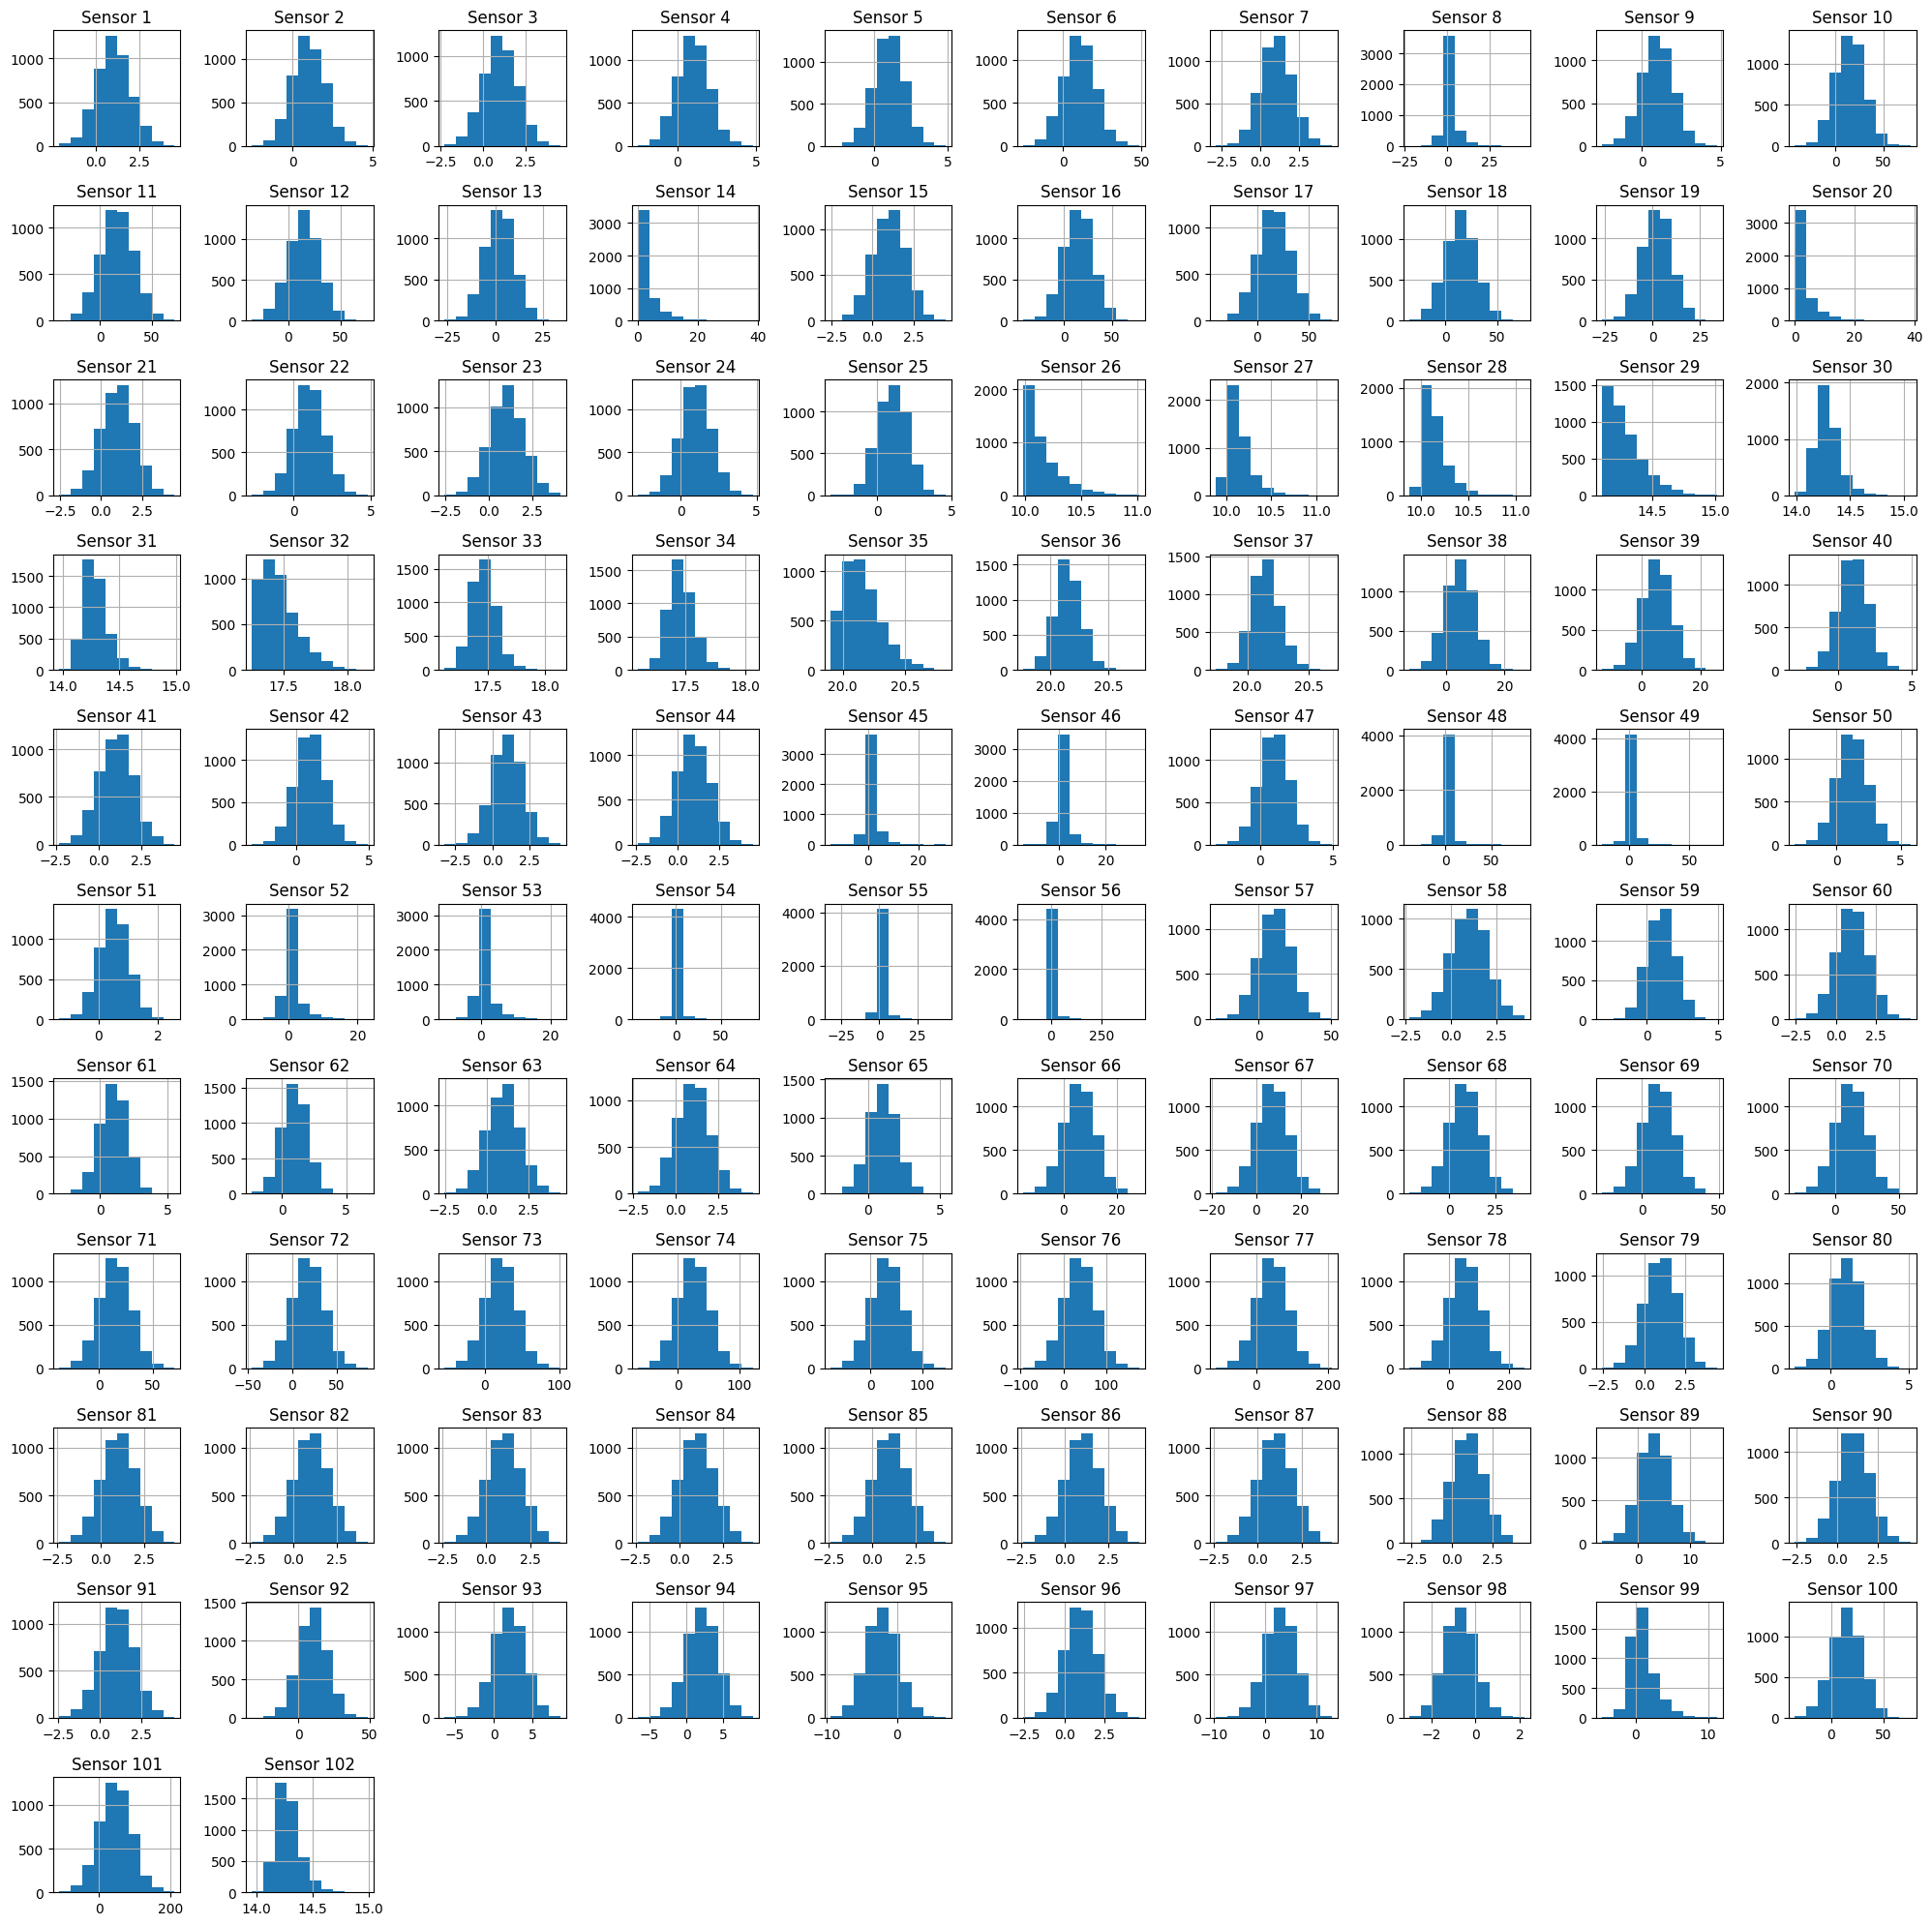

In [73]:
train.hist(figsize=(20, 20))
plt.tight_layout()
plt.show()

## View Correlation

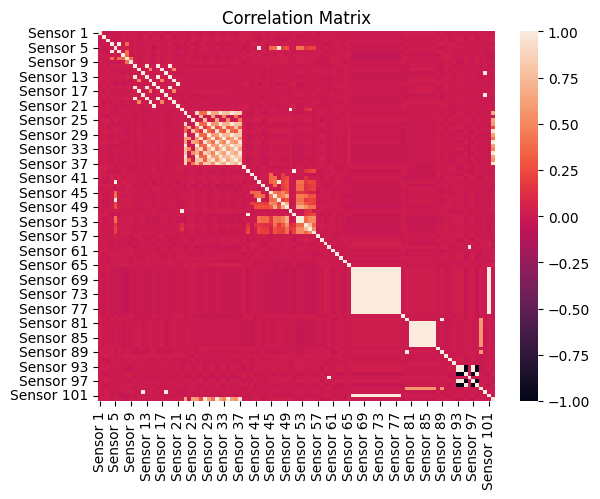

In [80]:
plt.title("Correlation Matrix")
sns.heatmap(train.select_dtypes(exclude="object").corr())
plt.show()

In [76]:
temp = train.copy()
temp["OneHotTarget"] = temp["Machine Failure"].apply(
    lambda x: 1 if x == "Failure" else 0
)

In [77]:
temp.head()

,Sensor 1,Sensor 2,Sensor 3,Sensor 4,Sensor 5,Sensor 6,Sensor 7,Sensor 8,Sensor 9,Sensor 10,Sensor 11,Sensor 12,Sensor 13,Sensor 14,Sensor 15,Sensor 16,Sensor 17,Sensor 18,Sensor 19,Sensor 20,Sensor 21,Sensor 22,Sensor 23,Sensor 24,Sensor 25,Sensor 26,Sensor 27,Sensor 28,Sensor 29,Sensor 30,Sensor 31,Sensor 32,Sensor 33,Sensor 34,Sensor 35,Sensor 36,Sensor 37,Sensor 38,Sensor 39,Sensor 40,Sensor 41,Sensor 42,Sensor 43,Sensor 44,Sensor 45,Sensor 46,Sensor 47,Sensor 48,Sensor 49,Sensor 50,Sensor 51,Sensor 52,Sensor 53,Sensor 54,Sensor 55,Sensor 56,Sensor 57,Sensor 58,Sensor 59,Sensor 60,Sensor 61,Sensor 62,Sensor 63,Sensor 64,Sensor 65,Sensor 66,Sensor 67,Sensor 68,Sensor 69,Sensor 70,Sensor 71,Sensor 72,Sensor 73,Sensor 74,Sensor 75,Sensor 76,Sensor 77,Sensor 78,Sensor 79,Sensor 80,Sensor 81,Sensor 82,Sensor 83,Sensor 84,Sensor 85,Sensor 86,Sensor 87,Sensor 88,Sensor 89,Sensor 90,Sensor 91,Sensor 92,Sensor 93,Sensor 94,Sensor 95,Sensor 96,Sensor 97,Sensor 98,Sensor 99,Sensor 100,Sensor 101,Sensor 102,Machine Failure,OneHotTarget
1526,1.382209,0.959569,2.039691,1.631576,1.471266,16.315762,-0.123216,-0.498342,1.487315,26.543901,-1.681403,-11.966185,8.271950,1.364552,0.740828,26.543901,-1.681403,-11.966185,8.271950,1.364552,0.740828,0.006143,1.029249,1.688247,-0.114838,10.103891,10.192126,10.051987,14.251942,14.314632,14.215192,17.439814,17.491081,17.409794,20.128993,20.173427,20.102989,13.478877,10.968783,0.855048,0.941854,1.471266,0.080731,1.921926,1.184856,0.111871,1.471266,0.183842,0.215007,0.007371,1.096878,0.228281,0.228281,0.001738,0.001846,0.057161,9.402169,2.727626,1.360505,-0.102864,1.930407,-0.818318,0.125710,1.763584,0.185371,12.595135,15.114162,18.136994,21.764393,26.117271,31.340726,37.608871,45.130645,54.156774,64.988129,77.985755,93.582906,112.299487,0.838036,1.828243,0.423469,0.423469,0.423469,0.423469,0.423469,0.423469,0.423469,1.205233,5.484730,2.798237,-0.796498,5.008164,-0.677723,-0.711609,0.745496,-0.102864,-1.016585,0.237203,0.774204,-11.966185,93.582906,14.215192,Running,0
2814,1.114661,1.753120,0.777757,-1.165778,1.167658,-11.657782,0.838125,-3.917132,2.405440,13.810468,24.548010,-7.777302,1.905234,2.116446,2.311702,13.810468,24.548010,-7.777302,1.905234,2.116446,2.311702,-0.103996,3.296675,1.798160,1.997290,10.684790,10.321340,10.357888,14.746573,14.485397,14.511462,17.909720,17.695293,17.716636,20.592590,20.406373,20.424883,5.172502,7.050766,1.598879,-0.457077,1.167658,0.196142,2.545204,-0.853337,-0.104683,1.167658,-0.426005,-0.266440,-0.124795,0.705077,0.582921,0.582921,0.023444,-0.051291,0.239583,17.280406,1.668045,2.203358,0.682722,0.674557,0.725812,1.600185,1.273691,2.517204,-5.784908,-6.941890,-8.330268,-9.996321,-11.995586,-14.394703,-17.273643,-20.728372,-24.874046,-29.848855,-35.818627,-42.982352,-51.578822,0.701181,1.843427,-0.579114,-0.579114,-0.579114,-0.579114,-0.579114,-0.579114,-0.579114,0.490554,5.530280,1.150180,-0.151168,28.697889,4.822310,5.063426,-5.304542,0.682722,7.233466,-1.687809,-1.067554,-7.777302,-42.982352,14.511462,Running,0
6488,0.919949,-0.244303,0.442553,-0.542031,0.603301,-5.420310,1.906050,-0.214311,0.124462,10.368780,5.364259,11.428224,0.184390,0.214901,1.932328,10.368780,5.364259,11.428224,0.184390,0.214901,1.932328,0.890976,2.327950,-0.493759,1.288856,10.380140,10.127771,10.197505,14.493973,14.314318,14.363741,17.674932,17.527911,17.568295,20.364949,20.237480,20.272468,9.373816,0.960958,-0.170585,1.305511,0.603301,-1.896878,1.550714,-0.134356,-1.494011,0.603301,0.395210,-2.316785,1.069172,0.096096,-1.774619,-1.774619,-0.238033,-0.182329,0.302632,-6.529273,2.817630,1.437235,0.890708,-0.619939,1.255193,2.166722,0.340220,0.894706,-4.591103,-5.509323,-6.611188,-7.933426,-9.520111,-11.424133,-13.708959,-16.450751,-19.740901,-23.689082,-28.426898,-34.112278,-40.934733,1.745349,-0.899083,-0.181665,-0.181665,-0.181665,-0.181665,-0.181665,-0.181665,-0.181665,0.453108,-2.697248,-0.844321,0.753698,19.702449,3.282184,3.446293,-3.610402,0.890708,4.923276,-1.148764,0.163332,11.42822

In [78]:
temp["OneHotTarget"].unique()

array([0, 1])

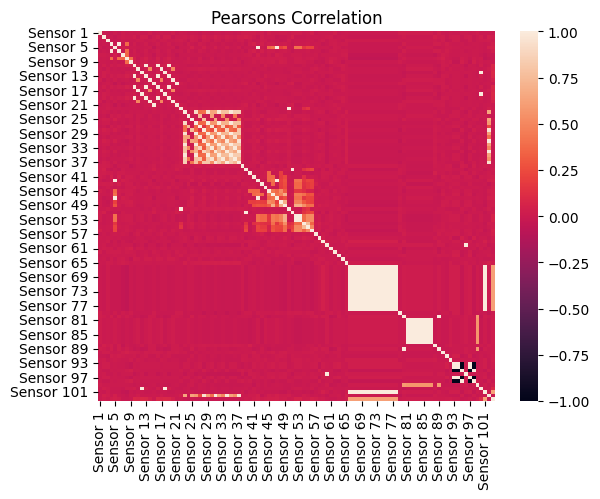

In [81]:
plt.title("Pearsons Correlation")
sns.heatmap(temp.select_dtypes(exclude="object").corr())
plt.show()

In [90]:
columns_to_analyse = [*list(temp.columns[64:77]), "OneHotTarget"]

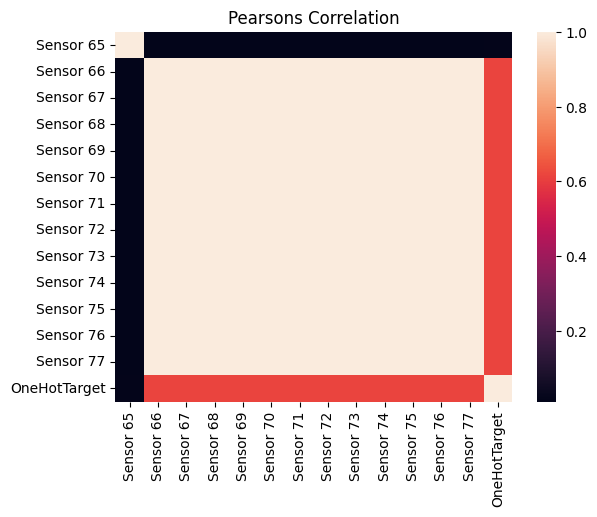

In [91]:
plt.title("Pearsons Correlation")
sns.heatmap(temp[columns_to_analyse].select_dtypes(exclude="object").corr())
plt.show()

## Is the target balanced?

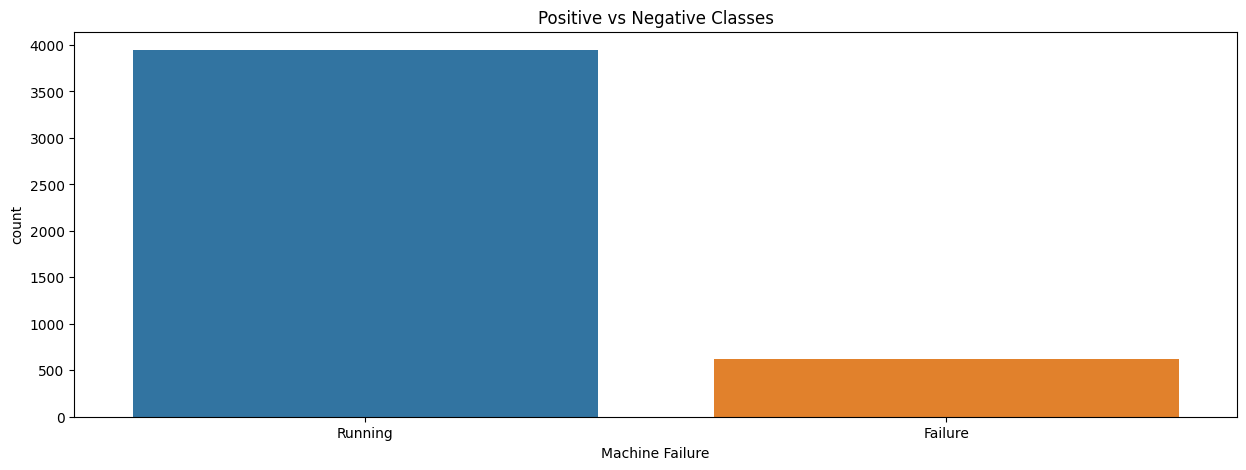

In [92]:
plt.figure(figsize=(15, 5))
sns.countplot(x="Machine Failure", data=train).set_title("Positive vs Negative Classes")
plt.show()

# 4. Preprocessing

## Split Features and Targets

In [93]:
# Create the training variables
X_train = train.drop("Machine Failure", axis=1)
y_train = train["Machine Failure"]

In [95]:
y_train.head()

1526    Running
2814    Running
6488    Running
66      Running
6077    Running
Name: Machine Failure, dtype: object

In [96]:
# Create test variables
X_test = test.drop("Machine Failure", axis=1)
y_test = test["Machine Failure"]

In [100]:
y_test.head()

5302    Running
4018    Running
4271    Running
2289    Running
4048    Running
Name: Machine Failure, dtype: object

## Rebalance Data

In [102]:
from imblearn.over_sampling import SMOTE

In [103]:
# Balance data using SMOTE
sm = SMOTE(random_state=1234)
X_train, y_train = sm.fit_resample(X_train, y_train)

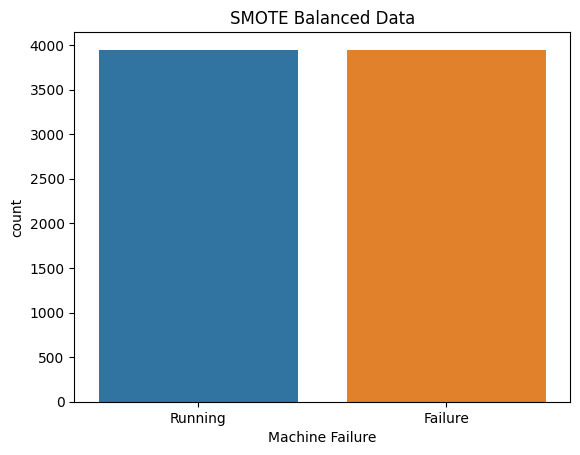

In [105]:
# Viz balanced data
sns.countplot(x=y_train).set_title("SMOTE Balanced Data")
plt.show()

# 5. Reducing Dimensionality

## Training a PCA Model

In [106]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [107]:
# Scale data prior to applying PCA
scaler = StandardScaler()
scaled_data = scaler.fit_transform(X_train)

In [111]:
temp_scaled_df = pd.DataFrame(scaled_data)
pd.reset_option("display.max_rows")
pd.reset_option("display.max_columns")

In [114]:
temp_scaled_df.describe()

,0,1,2,3,4,5,6,7,8,9,...,92,93,94,95,96,97,98,99,100,101
count,7.892000e+03,7.892000e+03,7.892000e+03,7.892000e+03,7.892000e+03,7.892000e+03,7.892000e+03,7.892000e+03,7.892000e+03,7.892000e+03,...,7.892000e+03,7.892000e+03,7.892000e+03,7.892000e+03,7.892000e+03,7.892000e+03,7.892000e+03,7.892000e+03,7.892000e+03,7.892000e+03
mean,-2.160799e-17,-2.340866e-17,-1.181687e-16,6.122264e-17,1.206446e-16,1.080399e-17,9.858645e-17,-5.401997e-18,5.221931e-17,-1.224453e-16,...,-5.041864e-17,2.574952e-16,2.250832e-16,1.134419e-16,6.122264e-17,4.861798e-17,6.977580e-17,-1.512559e-16,1.152426e-16,1.594129e-14
std,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00,...,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00
min,-3.515579e+00,-3.845679e+00,-3.579908e+00,-3.841792e+00,-4.201532e+00,-3.841792e+00,-4.161579e+00,-6.158237e+00,-3.713421e+00,-3.963535e+00,...,-4.334191e+00,-4.334191e+00,-3.405423e+00,-3.781765e+00,-4.334191e+00,-3.405423e+00,-3.527926e+00,-3.561962e+00,-3.675219e+00,-3.194254e+00
25%,-6.583024e-01,-6.636097e-01,-6.779631e-01,-6.632984e-01,-6.604401e-01,-6.632984e-01,-6.701770e-01,-4.343200e-01,-6.524550e-01,-6.928222e-01,...,-6.693872e-01,-6.693872e-01,-6.744032e-01,-6.509318e-01,-6.693872e-01,-6.744032e-01,-6.322599e-01,-6.486768e-01,-7.233773e-01,-6.746603e-01
50%,1.584948e-02,-1.393945e-02,-2.482697e-02,2.183235e-02,1.168272e-02,2.183235e-02,-1.383801e-02,-2.393664e-01,9.856393e-03,1.713052e-02,...,2.253858e-03,2.253858e-03,-2.253858e-03,-1.419766e-03,2.253858e-03,-2.253858e-03,-2.113705e-01,8.537181e-04,2.219962e-01,-1.434594e-01
75%,6.443632e-01,6.881833e-01,6.709745e-01,6.725482e-01,6.517591e-01,6.725482e-01,6.658612e-01,2.651041e-01,6.335938e-01,6.854011e-01,...,6.744032e-01,6.744032e-01,6.693872e-01,6.528772e-01,6.744032e-01,6.693872e-01,4.832545e-01,6.793036e-01,7.031462e-01,5.329125e-01
max,3.973761e+00,3.969557e+00,3.858896e+00,4.061023e+00,4.086740e+00,4.061023e+00,3.830458e+00,1.129896e+01,4.109549e+00,4.189699e+00,...,3.405423e+00,3.405423e+00,4.334191e+00,3.844042e+00,3.405423e+00,4.334191e+00,6.384088e+00,4.108624e+00,2.722767e+00,6.987032e+00


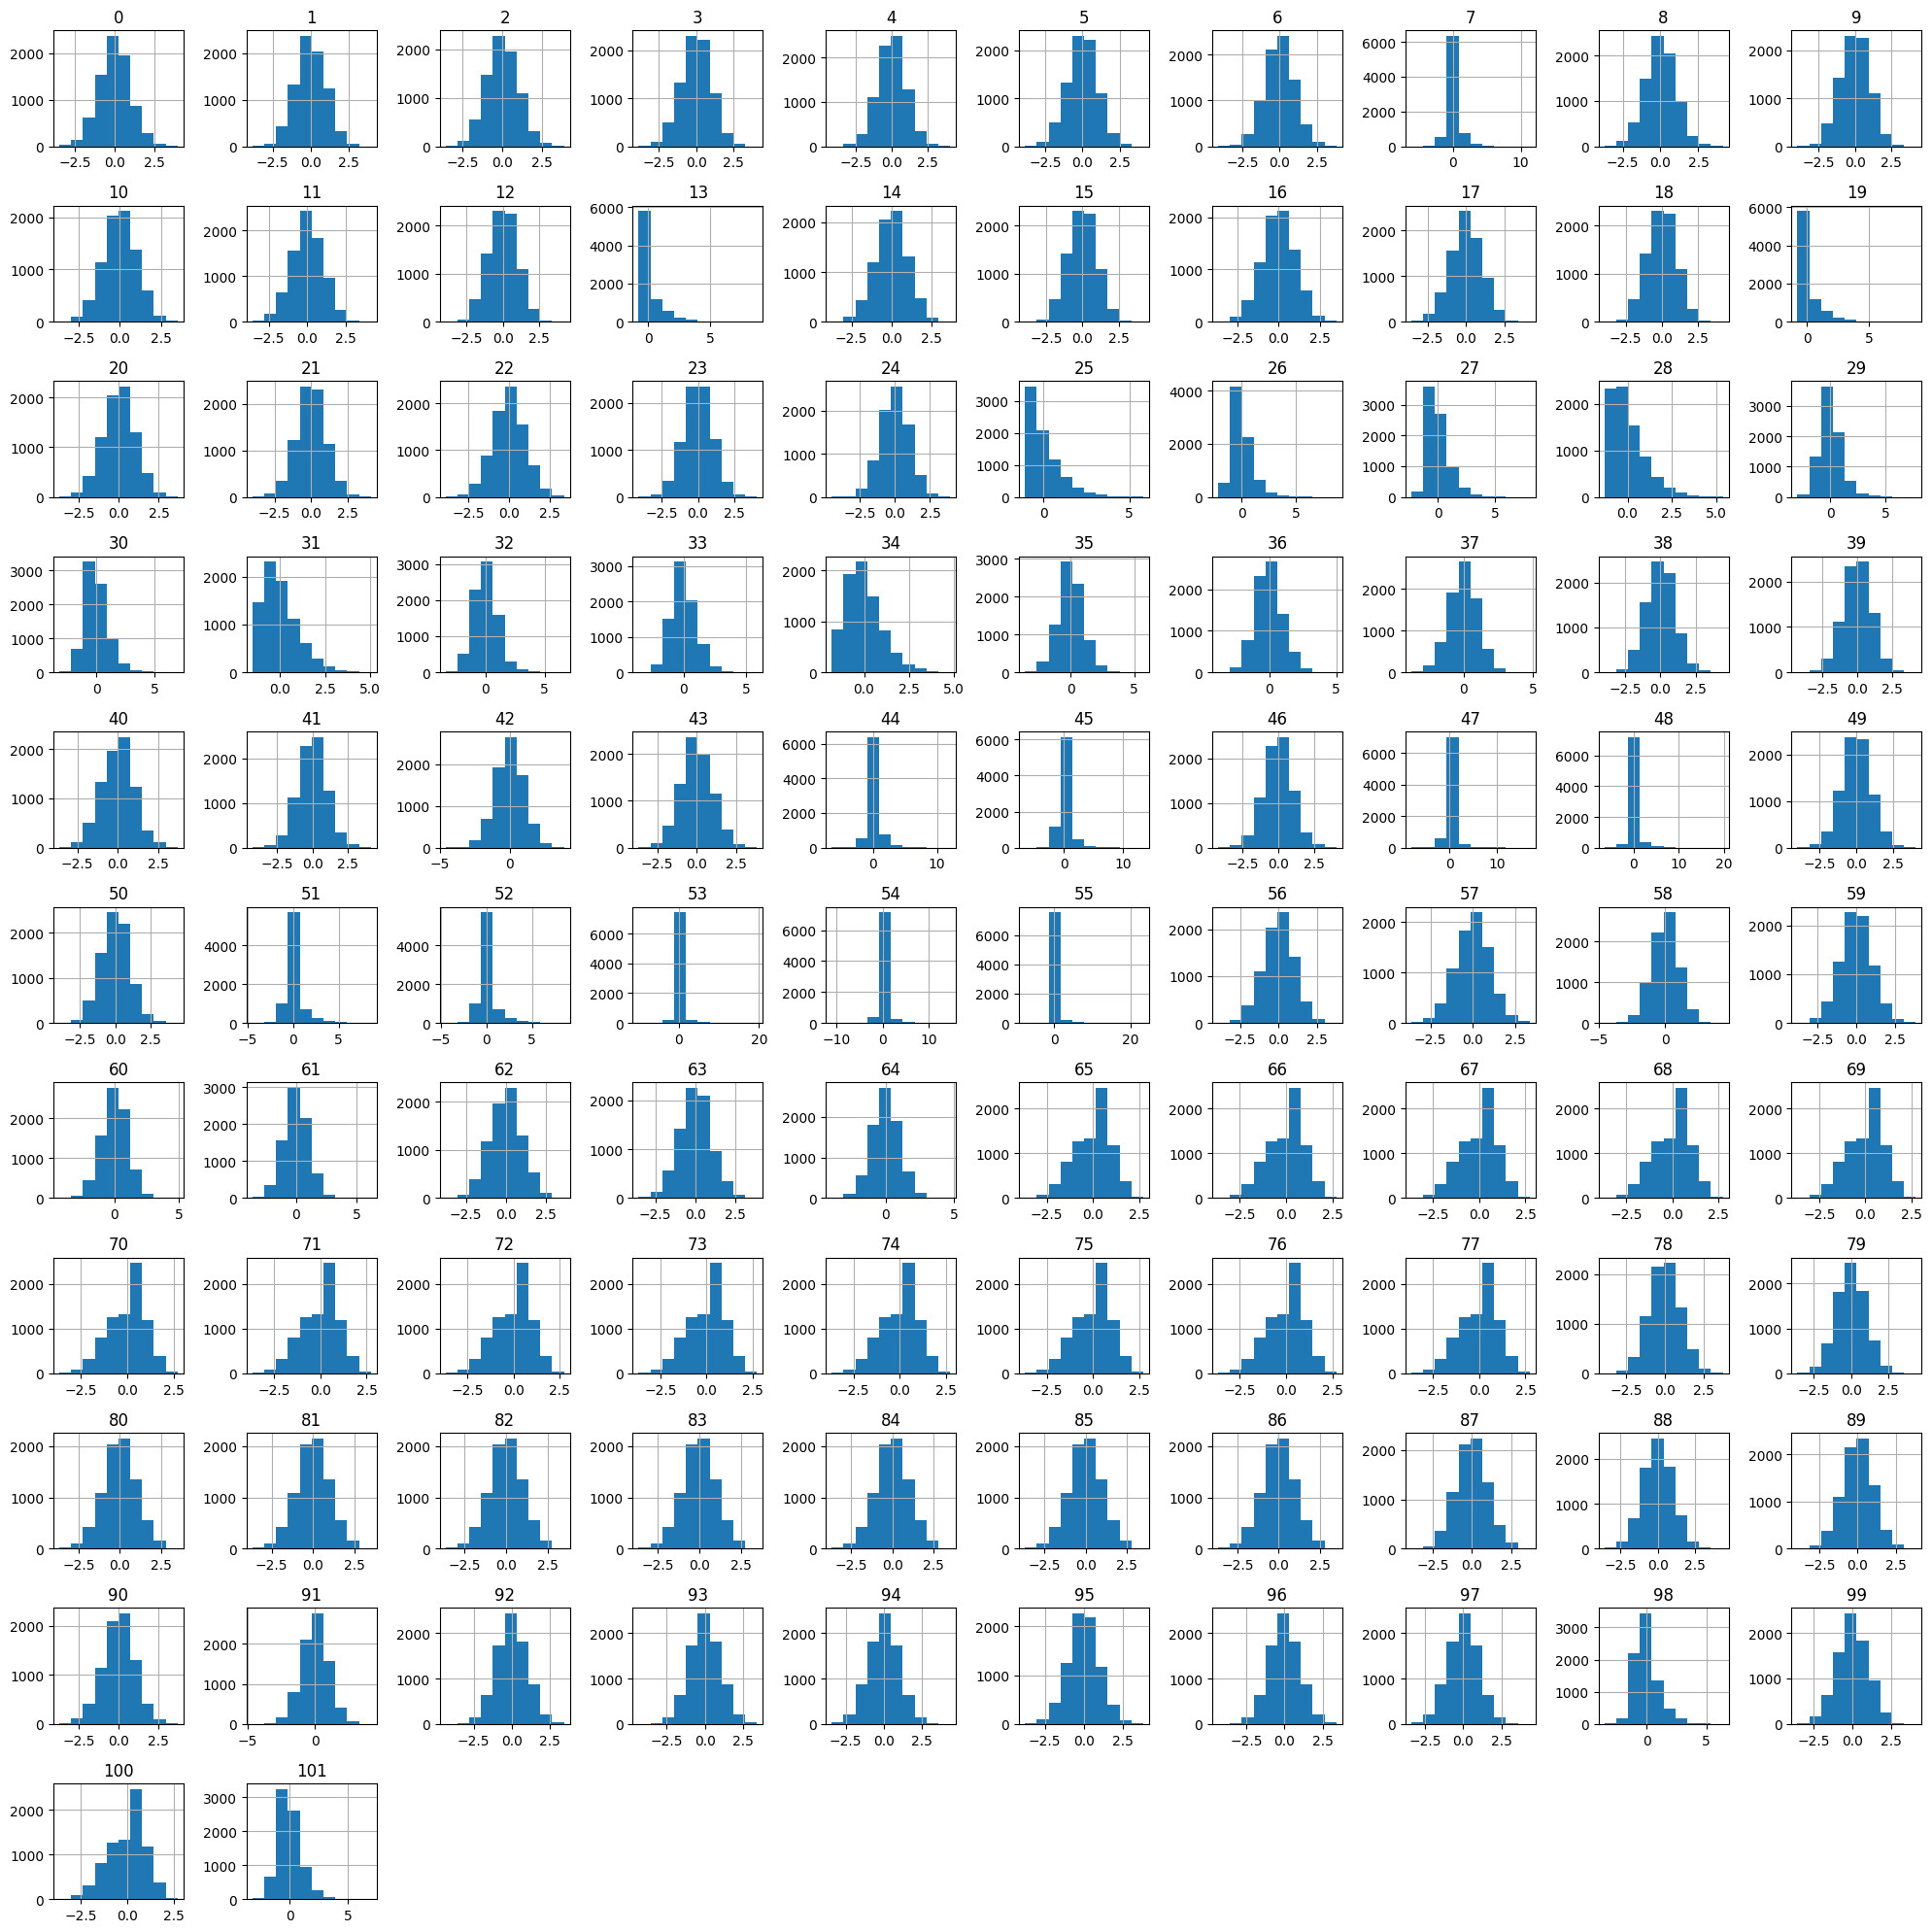

In [113]:
temp_scaled_df.hist(figsize=(20, 20))
plt.tight_layout()
plt.show()

In [115]:
fit_pca = {}
for component in range(2, len(X_train.columns) - 1):
    pca = PCA(n_components=component)
    pca.fit(scaled_data)
    fit_pca[component] = pca

## Evaluating Components using a Scree Plot

In [122]:
fit_pca[5].transform(scaled_data)[0]

array([-1.32661064, -0.79581783, -1.65666716, -0.903075  ,  2.92931953])

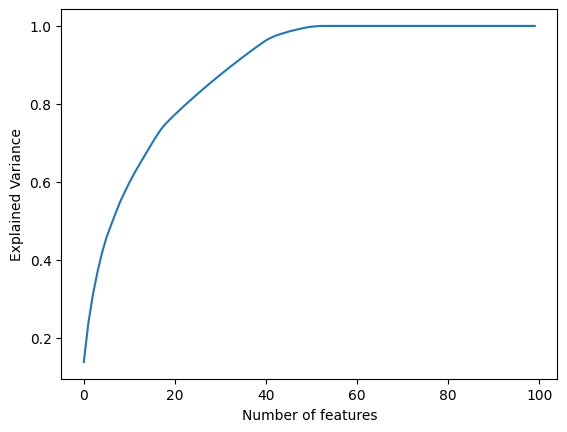

In [126]:
plt.plot(fit_pca[100].explained_variance_ratio_.cumsum())
plt.xlabel("Number of features")
plt.ylabel("Explained Variance")
plt.show()

# 6. Modelling

## Import Dependencies

In [128]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import RidgeClassifier, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

## Create Pipelines and Grids

In [130]:
pipelines = {
    "sgd": make_pipeline(
        StandardScaler(), PCA(n_components=50), SGDClassifier(random_state=1234)
    ),
    "ridge": make_pipeline(
        StandardScaler(), PCA(n_components=50), RidgeClassifier(random_state=1234)
    ),
    "rf": make_pipeline(
        StandardScaler(),
        PCA(n_components=50),
        RandomForestClassifier(random_state=1234),
    ),
    "gb": make_pipeline(
        StandardScaler(),
        PCA(n_components=50),
        GradientBoostingClassifier(random_state=1234),
    ),
}

In [132]:
pipelines["gb"].get_params()

{'memory': None,
 'steps': [('standardscaler', StandardScaler()),
  ('pca', PCA(n_components=50)),
  ('gradientboostingclassifier',
   GradientBoostingClassifier(random_state=1234))],
 'verbose': False,
 'standardscaler': StandardScaler(),
 'pca': PCA(n_components=50),
 'gradientboostingclassifier': GradientBoostingClassifier(random_state=1234),
 'standardscaler__copy': True,
 'standardscaler__with_mean': True,
 'standardscaler__with_std': True,
 'pca__copy': True,
 'pca__iterated_power': 'auto',
 'pca__n_components': 50,
 'pca__n_oversamples': 10,
 'pca__power_iteration_normalizer': 'auto',
 'pca__random_state': None,
 'pca__svd_solver': 'auto',
 'pca__tol': 0.0,
 'pca__whiten': False,
 'gradientboostingclassifier__ccp_alpha': 0.0,
 'gradientboostingclassifier__criterion': 'friedman_mse',
 'gradientboostingclassifier__init': None,
 'gradientboostingclassifier__learning_rate': 0.1,
 'gradientboostingclassifier__loss': 'log_loss',
 'gradientboostingclassifier__max_depth': 3,
 'gradientb

In [134]:
grid = {
    "sgd": {"sgdclassifier__alpha": [0.00001, 0.0001, 0.001, 0.01]},
    "ridge": {"ridgeclassifier__alpha": [0.01, 0.5, 1.0, 2.0, 3.0]},
    "rf": {
        "randomforestclassifier__n_estimators": [50, 100, 200, 300, 400],
        "randomforestclassifier__max_depth": [None, 5, 7, 9],
    },
    "gb": {
        "gradientboostingclassifier__n_estimators": [50, 100, 200, 300, 400],
        "gradientboostingclassifier__max_depth": [None, 5, 7, 9],
    },
}

## Train PCA Factored Models

In [135]:
y_train

0       Running
1       Running
2       Running
3       Running
4       Running
         ...   
7887    Failure
7888    Failure
7889    Failure
7890    Failure
7891    Failure
Name: Machine Failure, Length: 7892, dtype: object

In [137]:
fit_models = {}
for algo, pipeline in pipelines.items():
    try:
        print(f"Commencing training for {algo}")
        model = GridSearchCV(pipeline, grid[algo], cv=10, n_jobs=-1)
        model.fit(X_train, y_train)
        fit_models[algo] = model
        print(f"Completed training for {algo}")
    except Exception as e:
        print(f"Something went wrong with algo {algo}: {e}")

Commencing training for sgd
Completed training for sgd
Commencing training for ridge
Completed training for ridge
Commencing training for rf
Completed training for rf
Commencing training for gb
Completed training for gb


In [143]:
fit_models

{'sgd': GridSearchCV(cv=10,
              estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                        ('pca', PCA(n_components=50)),
                                        ('sgdclassifier',
                                         SGDClassifier(random_state=1234))]),
              n_jobs=-1,
              param_grid={'sgdclassifier__alpha': [1e-05, 0.0001, 0.001, 0.01]}),
 'ridge': GridSearchCV(cv=10,
              estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                        ('pca', PCA(n_components=50)),
                                        ('ridgeclassifier',
                                         RidgeClassifier(random_state=1234))]),
              n_jobs=-1,
              param_grid={'ridgeclassifier__alpha': [0.01, 0.5, 1.0, 2.0, 3.0]}),
 'rf': GridSearchCV(cv=10,
              estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                        ('pca', P

# 7. Evaluate

## Calculate Classification Metrics

In [144]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

In [145]:
# Loop through each algorithm
for algo, model in fit_models.items():
    # Make a prediction
    yhat = model.predict(X_test)
    # Convert the outcomes to binary variables
    y_test_bin = [1 if val == "Failure" else 0 for val in y_test]
    yhat_bin = [1 if val == "Failure" else 0 for val in yhat]

    f1 = f1_score(y_test_bin, yhat_bin)
    precision = precision_score(y_test_bin, yhat_bin)
    recall = recall_score(y_test_bin, yhat_bin)

    print(f"{algo} scores: F1:{f1}, Precision:{precision}, Recall:{recall}")

sgd scores: F1:0.9831775700934579, Precision:0.9850187265917603, Recall:0.9813432835820896
ridge scores: F1:0.7204301075268817, Precision:0.5630252100840336, Recall:1.0
rf scores: F1:0.8795620437956205, Precision:0.8607142857142858, Recall:0.8992537313432836
gb scores: F1:0.9194991055456171, Precision:0.8831615120274914, Recall:0.9589552238805971


## Review Confusion Matrix

In [146]:
model = fit_models["sgd"]

In [147]:
yhat = model.predict(X_test)
confusion_matrix(y_test, yhat, labels=["Failure", "Running"])

array([[ 263,    5],
       [   4, 1687]])

# 8. Deploy

## Save Model

In [148]:
import pickle

In [149]:
with open("sgd.pkl", "wb") as f:
    pickle.dump(fit_models["sgd"], f)

## Load Model and PCA

In [150]:
with open("sgd.pkl", "rb") as f:
    best_model = pickle.load(f)

In [151]:
best_model.best_estimator_

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=50)),
                ('sgdclassifier',
                 SGDClassifier(alpha=0.001, random_state=1234))])

## Call New Data to Be Scored

In [152]:
con = sqlite3.connect(DB_PATH)
cur = con.cursor()

In [153]:
ALL_DATA_STATEMENT = """
    SELECT
        *
    FROM
        scoring
"""

In [154]:
res = cur.execute(ALL_DATA_STATEMENT)
scoring_data = res.fetchall()

In [156]:
scoring_data[0]

(0.585750267,
 0.710869607,
 0.961794667,
 0.535206619,
 1.327430447,
 5.352066187,
 2.22607639,
 -1.417258473,
 -0.713737924,
 8.562829403,
 16.39160088,
 4.951562638,
 -0.718585299,
 0.408525618,
 1.355492864,
 8.562829403,
 16.39160088,
 4.951562638,
 -0.718585299,
 0.408525618,
 1.355492864,
 3.428719582,
 1.106577233,
 1.11514823,
 1.323574168,
 10.11588308,
 10.11682425,
 10.14191431,
 14.2631577,
 14.26382522,
 14.28163167,
 17.45119609,
 17.45174167,
 17.46629841,
 20.14077511,
 20.14124784,
 20.1538621,
 7.780123508,
 3.931760705,
 0.584022231,
 1.122251072,
 1.327430447,
 0.226696568,
 0.448505463,
 0.870023899,
 0.3377122,
 1.327430447,
 0.088459375,
 0.151465766,
 4.114463499,
 0.393176071,
 0.134966025,
 0.134966025,
 0.245027471,
 0.218335698,
 0.007162028,
 7.584955892,
 0.680767942,
 0.936767115,
 1.848734853,
 5.897993892,
 7.07759267,
 0.680767942,
 0.379614982,
 2.326892699,
 7.07759267,
 8.493111204,
 10.19173345,
 12.23008013,
 14.67609616,
 17.61131539,
 21.133578

In [157]:
col = np.array(cur.description)[:, 0]
scoring = pd.DataFrame(scoring_data, columns=col)
scoring.head()

,Sensor 1,Sensor 2,Sensor 3,Sensor 4,Sensor 5,Sensor 6,Sensor 7,Sensor 8,Sensor 9,Sensor 10,...,Sensor 93,Sensor 94,Sensor 95,Sensor 96,Sensor 97,Sensor 98,Sensor 99,Sensor 100,Sensor 101,Sensor 102
0,0.585750,0.710870,0.961795,0.535207,1.327430,5.352066,2.226076,-1.417258,-0.713738,8.562829,...,2.026752,2.128090,-2.229427,1.848735,3.040128,-0.709363,2.262458,4.951563,52.587106,14.281632
1,1.394299,0.528989,0.403531,0.562596,1.060444,5.625960,1.060982,1.135943,1.141834,28.130973,...,1.035123,1.086879,-1.138635,1.508479,1.552685,-0.362293,-0.873339,16.082543,24.111206,14.334397
2,2.269294,0.324147,-0.033710,2.277046,-0.041533,22.770459,2.366656,-13.778314,-1.534053,13.036520,...,1.726419,1.812740,-1.899061,1.184088,2.589629,-0.604247,0.854719,9.455773,70.558905,14.330505
3,1.246255,1.932317,2.315582,0.766818,1.328568,7.668182,3.359558,4.186759,0.975112,-0.464028,...,0.797737,0.837624,-0.877511,-0.106852,1.196606,-0.279208,-0.881114,23.510027,84.022643,14.339029
4,0.325781,1.895224,0.821280,2.313757,0.544863,23.137572,0.278491,0.412551,0.384150,14.307797,...,4.407654,4.628036,-4.848419,-0.632701,6.611480,-1.542679,4.790277,18.829649,75.828002,14.474880


## Make Predictions

In [162]:
yhat = best_model.predict(scoring)
yhat

array(['Running', 'Running', 'Running', ..., 'Running', 'Running',
       'Running'], dtype='<U7')

In [164]:
scoring["Predictions"] = yhat
scoring[scoring["Predictions"] == "Failure"]

,Sensor 1,Sensor 2,Sensor 3,Sensor 4,Sensor 5,Sensor 6,Sensor 7,Sensor 8,Sensor 9,Sensor 10,...,Sensor 94,Sensor 95,Sensor 96,Sensor 97,Sensor 98,Sensor 99,Sensor 100,Sensor 101,Sensor 102,Predictions
6,-0.078387,2.110458,0.130328,0.725025,3.172707,7.250250,1.560629,0.082053,0.043510,-14.519905,...,2.406553,-2.521151,-0.165369,3.437933,-0.802184,0.751085,9.883227,78.753949,14.170723,Failure
24,-0.256254,2.119283,0.671730,0.663645,1.584472,6.636452,0.175151,0.304721,1.572918,-3.853938,...,3.546111,-3.714973,1.948698,5.065872,-1.182037,1.653248,27.423542,150.307337,14.194555,Failure
28,0.897561,2.505827,-0.203300,1.127276,-0.409926,11.272764,0.107353,0.077619,0.384833,25.825179,...,3.751139,-3.929764,1.010349,5.358770,-1.250380,2.178797,39.444315,96.050098,14.446836,Failure
32,1.963220,-0.499877,1.121868,1.125154,2.286975,11.251539,0.294067,0.908792,1.648004,6.219810,...,0.468033,-0.490320,2.134201,0.668618,-0.156011,-0.735163,18.647904,161.108554,14.145058,Failure
43,1.836739,1.458990,1.096666,0.346044,0.423312,3.460439,1.739671,-0.505383,-0.503702,30.932965,...,2.215962,-2.321484,0.727127,3.165660,-0.738654,-0.625000,4.323798,120.441302,14.234474,Failure
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2135,1.591741,1.727968,0.856942,2.335187,0.237468,23.351870,2.071762,-2.759542,-0.342237,11.806134,...,3.294372,-3.451247,1.128791,4.706245,-1.098124,-0.607904,1.999776,101.669242,14.261475,Failure
2136,1.442653,1.064387,1.790435,-2.006418,0.362424,-20.064180,2.742726,0.531228,-0.057920,5.622461,...,-0.488309,0.511562,-0.343440,-0.697584,0.162770,3.605998,30.417814,101.690546,14.247132,Failure
2140,1.032776,1.351728,-0.235847,1.060129,1.620374,10.601290,-0.361086,-1.003399,1.572735,30.135028,...,3.441591,-3.605476,-0.404022,4.916558,-1.147197,1.955478,-3.487685,122.925221,14.166708,Failure
2142,1.057368,1.920207,1.021273,-0.181090,2.074347,-1.810898,2.689663,-0.018764,0.023114,39.183065,...,3.380125,-3.541083,0.964521,4.828750,-1.126708,0.122994,11.096744,93.265483,14.491024,Failure


## Check if Predictions Table Exists, If Not Create It

In [165]:
PREDICTIONS_TABLE = """
    SELECT
        name
    FROM
        sqlite_master
    WHERE
        type="table"
    AND
        name="predictions";
"""

In [175]:
res = cur.execute(PREDICTIONS_TABLE)
tables = res.fetchall()

In [176]:
tables

[('predictions',)]

In [174]:
cur.execute(f"CREATE TABLE predictions {tuple(scoring.columns)}")

## Push back into Database

In [180]:
tups = [tuple(val) for val in scoring.values]
val_template = str("?," * len(tups[0]))[:-1]
val_template

'?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?'

In [181]:
cur.executemany(f"INSERT INTO predictions VALUES ({val_template})", tups)

## View Loaded Results

In [182]:
res = cur.execute("SELECT * FROM predictions")
predictions = res.fetchall()

In [185]:
sql_columns = np.array(cur.description)[:, 0]
sql_predictions = pd.DataFrame(predictions, columns=sql_columns)
sql_predictions.head()

,Sensor 1,Sensor 2,Sensor 3,Sensor 4,Sensor 5,Sensor 6,Sensor 7,Sensor 8,Sensor 9,Sensor 10,...,Sensor 94,Sensor 95,Sensor 96,Sensor 97,Sensor 98,Sensor 99,Sensor 100,Sensor 101,Sensor 102,Predictions
0,0.585750,0.710870,0.961795,0.535207,1.327430,5.352066,2.226076,-1.417258,-0.713738,8.562829,...,2.128090,-2.229427,1.848735,3.040128,-0.709363,2.262458,4.951563,52.587106,14.281632,Running
1,1.394299,0.528989,0.403531,0.562596,1.060444,5.625960,1.060982,1.135943,1.141834,28.130973,...,1.086879,-1.138635,1.508479,1.552685,-0.362293,-0.873339,16.082543,24.111206,14.334397,Running
2,2.269294,0.324147,-0.033710,2.277046,-0.041533,22.770459,2.366656,-13.778314,-1.534053,13.036520,...,1.812740,-1.899061,1.184088,2.589629,-0.604247,0.854719,9.455773,70.558905,14.330505,Running
3,1.246255,1.932317,2.315582,0.766818,1.328568,7.668182,3.359558,4.186759,0.975112,-0.464028,...,0.837624,-0.877511,-0.106852,1.196606,-0.279208,-0.881114,23.510027,84.022643,14.339029,Running
4,0.325781,1.895224,0.821280,2.313757,0.544863,23.137572,0.278491,0.412551,0.384150,14.307797,...,4.628036,-4.848419,-0.632701,6.611480,-1.542679,4.790277,18.829649,75.828002,14.474880,Running


In [186]:
scoring.head()

,Sensor 1,Sensor 2,Sensor 3,Sensor 4,Sensor 5,Sensor 6,Sensor 7,Sensor 8,Sensor 9,Sensor 10,...,Sensor 94,Sensor 95,Sensor 96,Sensor 97,Sensor 98,Sensor 99,Sensor 100,Sensor 101,Sensor 102,Predictions
0,0.585750,0.710870,0.961795,0.535207,1.327430,5.352066,2.226076,-1.417258,-0.713738,8.562829,...,2.128090,-2.229427,1.848735,3.040128,-0.709363,2.262458,4.951563,52.587106,14.281632,Running
1,1.394299,0.528989,0.403531,0.562596,1.060444,5.625960,1.060982,1.135943,1.141834,28.130973,...,1.086879,-1.138635,1.508479,1.552685,-0.362293,-0.873339,16.082543,24.111206,14.334397,Running
2,2.269294,0.324147,-0.033710,2.277046,-0.041533,22.770459,2.366656,-13.778314,-1.534053,13.036520,...,1.812740,-1.899061,1.184088,2.589629,-0.604247,0.854719,9.455773,70.558905,14.330505,Running
3,1.246255,1.932317,2.315582,0.766818,1.328568,7.668182,3.359558,4.186759,0.975112,-0.464028,...,0.837624,-0.877511,-0.106852,1.196606,-0.279208,-0.881114,23.510027,84.022643,14.339029,Running
4,0.325781,1.895224,0.821280,2.313757,0.544863,23.137572,0.278491,0.412551,0.384150,14.307797,...,4.628036,-4.848419,-0.632701,6.611480,-1.542679,4.790277,18.829649,75.828002,14.474880,Running
